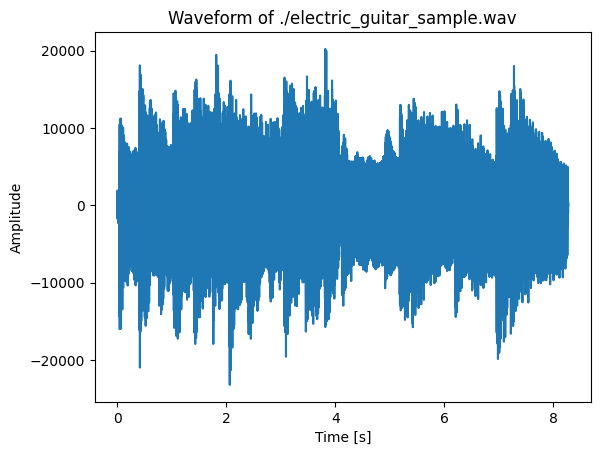

In [1]:
# open wave file and plot as input waveform

import wave
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile

file_path = "./electric_guitar_sample.wav"

with wave.open(file_path, 'r') as wave_file:
    # get the number of frames
    n_frames = wave_file.getnframes()
    # read the frames
    frames = wave_file.readframes(n_frames)
    # convert frames to integers
    frames = np.frombuffer(frames, dtype=np.int16)

    # get the frame rate
    frame_rate = wave_file.getframerate()*2 # there are 2 samples per frame, so technically this is sample rate rather than frame rate
    # get the time values for the x axis
    time = np.linspace(0, len(frames) / frame_rate, num=len(frames))

    # plot the waveform
    plt.figure()
    plt.plot(time, frames, label='Waveform')
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')
    plt.title('Waveform of ' + file_path)
    plt.show()


In [5]:
#playback origianl waveform using pyaudio NOT SUPPORTED ON PYNQ
import pyaudio

# set up the audio stream
p = pyaudio.PyAudio()
stream = p.open(format=pyaudio.paInt16, channels=1, rate=frame_rate, output=True)

# play the audio
stream.write(frames.tobytes())


In [6]:
# save frames to .wav file
wavfile.write('outputs/original.wav', frame_rate, frames)

# Distortion Algorithm

In [21]:
def distort(waveform: np.ndarray, threshold: int, clip_factor: float) -> list:
    """Distort the waveform by clipping the values above the threshold and below the negative threshold and softening the clipped values."""
    # This function will be replaced by HLS code
    distorted_waveform = waveform

    # apply clipping
    distorted_waveform = np.where(distorted_waveform > threshold, (distorted_waveform - threshold) * clip_factor + threshold, distorted_waveform)
    distorted_waveform = np.where(distorted_waveform <  -threshold, (distorted_waveform - threshold) * clip_factor - threshold, distorted_waveform)
    # print(type(waveform))
    # print(type(distorted_waveform))
    distorted_waveform = distorted_waveform.astype(np.int16)
    return distorted_waveform
    
    
    

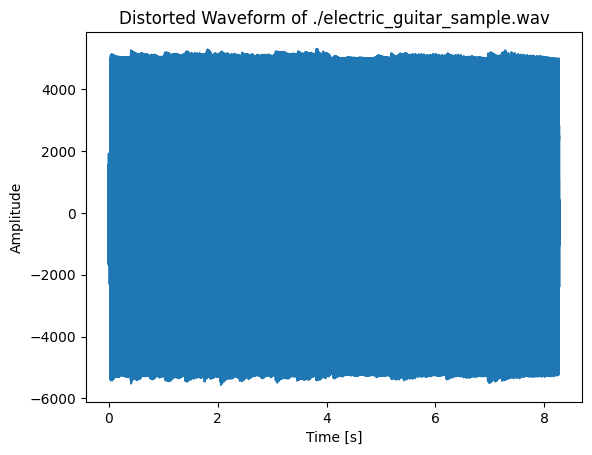

In [22]:
distorted_frames = frames # make a copy of the original waveform

threshold = 5000 # this is the amplitude that will start the audio clipping
clip_factor = 0.02 # this is the factor that will soften the clipped audio

distorted_frames = distort(distorted_frames, threshold, clip_factor)

# plot the waveform
plt.figure()
plt.plot(time, distorted_frames, label='Waveform')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Distorted Waveform of ' + file_path)
plt.show()

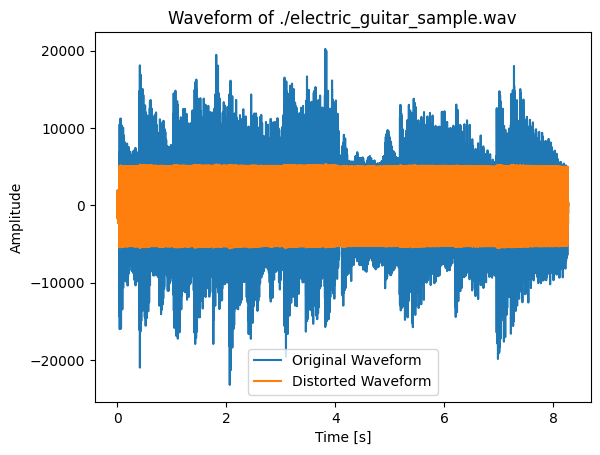

[ 0.  0. 42. ...  4.  4.  2.]


In [19]:
#plot frames and distored frames together to show the difference
plt.figure()
plt.plot(time, frames, label='Original Waveform')
plt.plot(time, distorted_frames, label='Distorted Waveform')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Waveform of ' + file_path)
plt.legend()
plt.show()
print(distorted_frames)

In [10]:
#playback waveform using pyaudio NOT SUPPORTED ON PYNQ
import pyaudio

# set up the audio stream
p = pyaudio.PyAudio()
stream = p.open(format=pyaudio.paInt16, channels=1, rate=frame_rate, output=True)

# play the audio
stream.write(distorted_frames.tobytes())


In [23]:
# save frames to .wav file
wavfile.write('outputs/distorted.wav', frame_rate, distorted_frames)

# Compression Algorithm

In [10]:
# Amplitude detection used in compression algorithm

def detect_amplitude(waveform: np.array) -> list:
    """Returns a np.array of equal lenght corresponding to the amplitude of the waveform at that point."""
    # This function will be replaced by HLS code
    rectified_signal = np.abs(waveform)

    # now apply a low pass filter to the rectified signal to envelop detect
    filter_length = frame_rate // 5 # frame rate over lowest frequency
    filter = np.ones(filter_length) / filter_length # create a filter which will just average the signal over the filter length
    envelope = np.convolve(rectified_signal, filter, mode='same') # convolve filter with signal
    #amplify to match amplitude
    envelope = envelope * 3
    return envelope


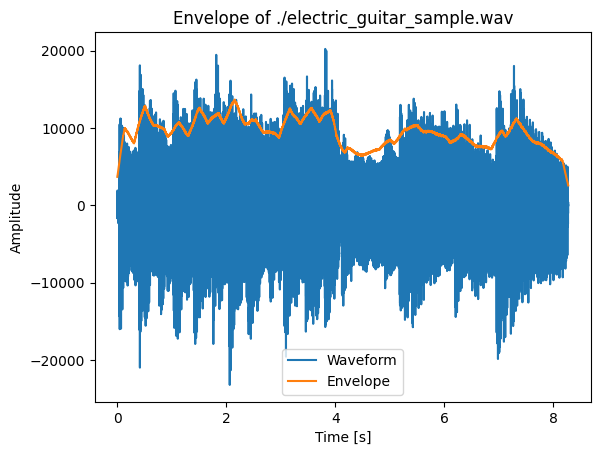

In [11]:
# plot the envelope of the waveform with the waveform
#on pynq board, userwarning will be generated but plot will still be generated after a long time
plt.figure()
plt.plot(time, frames, label='Waveform')
plt.plot(time, detect_amplitude(frames), label='Envelope')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Envelope of ' + file_path)
plt.legend()
plt.show()


In [12]:
# compression algorithm!

def compress(waveform: np.array, min_threshold: int, max_threshold: int, zero_threshold: int) -> list:
    """Compress the waveform by reducing the amplitude of the values above the threshold by the given ratio."""
    # This function will be replaced by HLS code
    envelope = detect_amplitude(waveform)
    compressed_waveform = list(waveform)
    # if sample is not loud enough, make louder, if too loud make quiter
    for i, sample in enumerate(compressed_waveform):
        if envelope[i] > max_threshold:
            compression_factor = envelope[i] / max_threshold
            compressed_waveform[i] = sample / compression_factor
        elif envelope[i] < min_threshold and envelope[i] > zero_threshold:
            compression_factor = min_threshold / envelope[i]
            compressed_waveform[i] = sample * compression_factor
    
    compressed_waveform = np.array(compressed_waveform, dtype="int16")
    return compressed_waveform

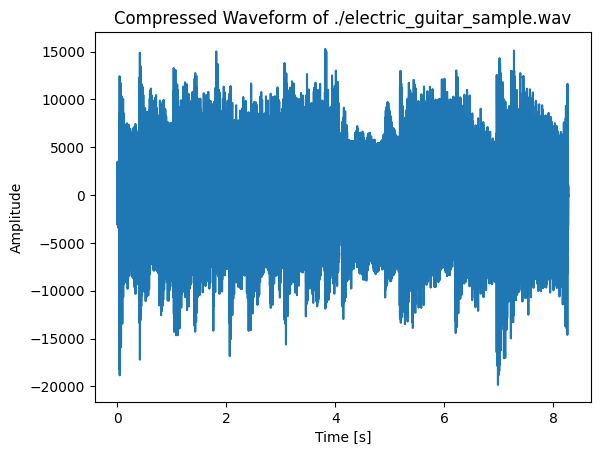

In [13]:
# calculate the whole waveform and plot
compressed_frames = compress(frames, 7000, 9000, 1000)
plt.figure()
plt.plot(time, compressed_frames, label='Waveform')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Compressed Waveform of ' + file_path)
plt.show()


C:\Users\kaden\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


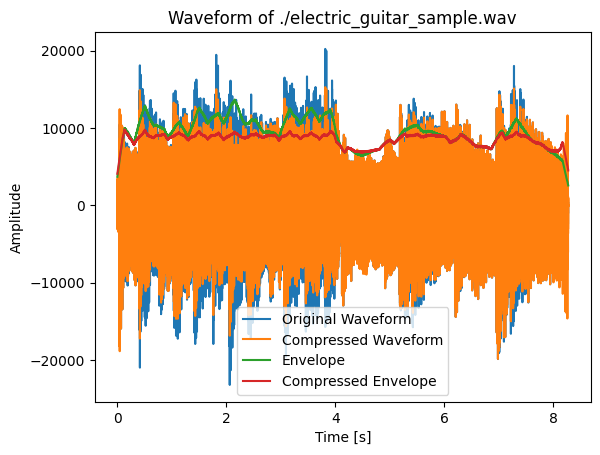

In [14]:
# plot the compressed waveform with the original to compare visually
#plot frames and distored frames together to show the difference
plt.figure()
plt.plot(time, frames, label='Original Waveform')
plt.plot(time, compressed_frames, label='Compressed Waveform')
# asd respective envelopes
plt.plot(time, detect_amplitude(frames), label='Envelope')
plt.plot(time, detect_amplitude(compressed_frames), label='Compressed Envelope')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Waveform of ' + file_path)
plt.legend()
plt.show()

# note that envelope is more steady on compressed waveform, which is what is wanted!

In [16]:
# playback compressed waveform
#playback distorted waveform using pyaudio NOT SUPPPORTED BY PYNQ
import pyaudio

# set up the audio stream
p = pyaudio.PyAudio()
stream = p.open(format=pyaudio.paInt16, channels=1, rate=frame_rate, output=True)
# play the audio
stream.write(compressed_frames.tobytes())




In [15]:
# save frames to .wav file
wavfile.write('outputs/compressed.wav', frame_rate, compressed_frames)